# Perturbing graph structure

In [1]:
import torchvision
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Scale
from torch.utils.data.dataloader import DataLoader
from torch.nn.functional import one_hot
from graph_autoencoder import LatentGraphVAE
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from datetime import datetime
import os

/home/bglaze/miniconda3/envs/graph_autoencoder/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def to_np(tnsr):
    return tnsr.detach().cpu().numpy().transpose((1,2,0))

In [3]:
device='cuda:3'

In [4]:
transforms = Compose([
    ToTensor(),
    Resize((320//2, 480//2)),
    ])
dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=1)

In [5]:
lgvae = LatentGraphVAE(n_channels=3, w=480//2, h=320//2, device=device)

In [6]:
sd = torch.load('models/lgvae_20221209-0934.torch')

In [7]:
lgvae.load_state_dict(sd)

<All keys matched successfully>

In [8]:
lgvae = lgvae.to(device)

In [9]:
idl = iter(dataloader)

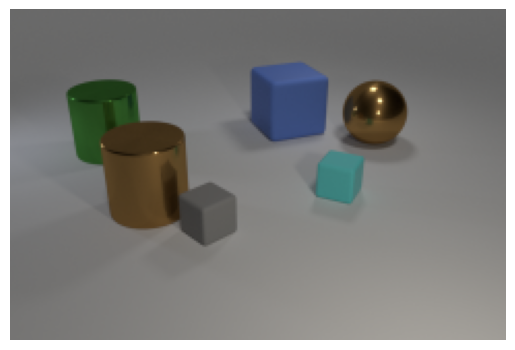

In [10]:
image,_ = next(idl)
image = image.to(device)
plt.axis('off')
# TODO why is this transposed?
plt.imshow(to_np(image.squeeze(0)))

/home/bglaze/miniconda3/envs/graph_autoencoder/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


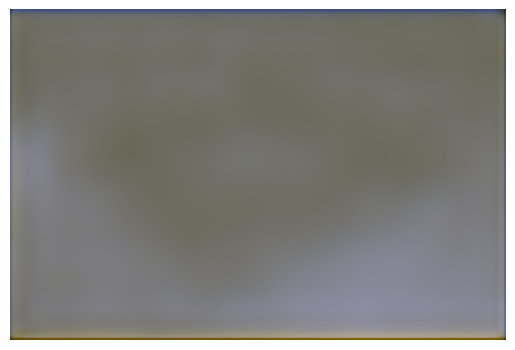

In [11]:
recon, nodes, attentions = lgvae(image.squeeze(0))

plt.axis('off')
plt.imshow(to_np(recon.squeeze(0)))

In [12]:
def remove_node(nodes, edge_index, node_idx):
    new_edges = edge_index[:,(edge_index != node_idx).sum(dim=0) == 2]
    new_nodes_mask = torch.arange(nodes.shape[0]) == node_idx
    new_nodes = torch.clone(nodes)
    new_nodes[new_nodes_mask]=0.0
    return nodes, new_edges

In [13]:
max_nodes = 8
a = torch.combinations(torch.arange(max_nodes), r=2)
b = a[:,[1,0]]
edge_index = torch.vstack((a,b)).t().to(device)

In [14]:
edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4,
         4, 5, 5, 6, 1, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 3, 4, 5, 6, 7, 4, 5,
         6, 7, 5, 6, 7, 6, 7, 7],
        [1, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 3, 4, 5, 6, 7, 4, 5, 6, 7, 5, 6,
         7, 6, 7, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3,
         3, 3, 4, 4, 4, 5, 5, 6]], device='cuda:3')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


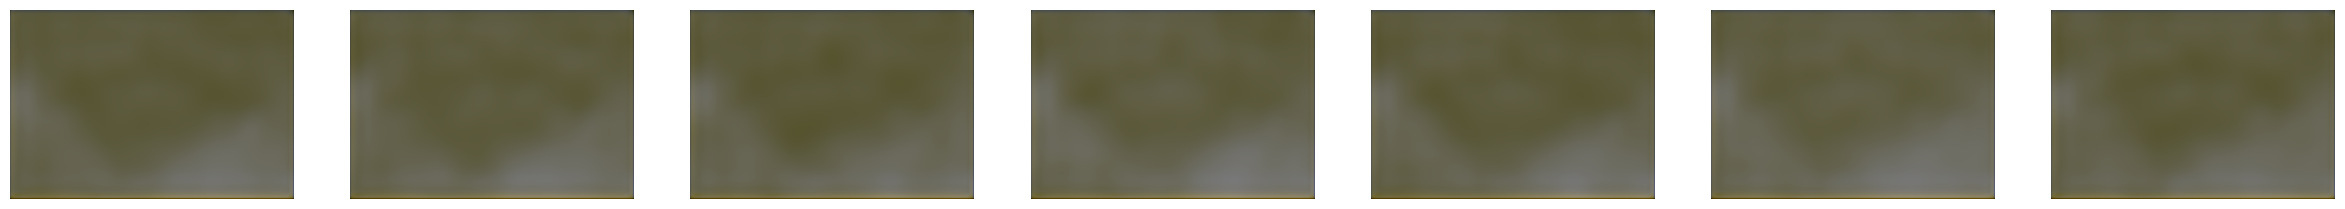

In [24]:
fig, axs = plt.subplots(1,7, figsize=(30,20))
for i in range(7):
    n,e = remove_node(nodes, edge_index, i)
    perturbed_nodes, _ = lgvae.graph_encode(n, e)
    perturbed = lgvae.decode(perturbed_nodes)
    axs[i].axis('off')
    axs[i].imshow(to_np(perturbed.squeeze(0)))